In [1]:
#!pip install ipywidgets
import torch
import numpy as np
import pandas as pd
import os
import torch
import re
import emoji
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score
from transformers import BertTokenizer, TFBertModel
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import DistilBertTokenizerFast
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-10 15:53:42.180366: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 15:53:42.206852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 15:53:43.988459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Adapted from https://www.kaggle.com/code/chayan8/sentiment-analysis-using-bert-pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
def hashtag(text):
  FLAGS = re.MULTILINE | re.DOTALL
  text = text.group()
  hashtag_body = text[1:]
  if hashtag_body.isupper():
      result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
  else:
      result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
  return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " 

def clean_data(text):
  FLAGS = re.MULTILINE | re.DOTALL
  eyes = r"[8:=;]"
  nose = r"['`\-]?"
  def re_sub(pattern, repl):
      return re.sub(pattern, repl, text, flags=FLAGS)

  text = emoji.demojize(text)
  text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
  text = re_sub(r"@\w+", "<user>")
  text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
  text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
  text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
  text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
  text = re_sub(r"/"," / ")
  text = re_sub(r"<3","<heart>")
  text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
  text = re_sub(r"#\w+", hashtag)
  text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
  text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

  text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
  text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
  text = re_sub(r"  ", r" ")
  text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
  return text.lower()

def preprocessing_tweet(tweet_df):
  temp_list= []
  for t in tweet_df['text']:
    temp_list.append(clean_data(t))
  tweet_df['clean_text'] = temp_list
  return tweet_df

In [4]:
df = pd.read_csv("data/train_2024.csv", quoting=3)
test_df = pd.read_csv("data/dev_2024.csv", quoting=3)
df.head()

,id,text,label
0,0,Except that Desmond played first base last nig...,0
1,1,What i find funny is the loyalty and blindness...,0
2,2,Read the article not just the headline & you ...,0
3,3,Speaking of a horses backside is that where y...,1
4,4,Michael Barone- gee are you dumb. No other wo...,1


In [5]:
train_df = preprocessing_tweet(df)
test_df = preprocessing_tweet(test_df)
train_df.head()

,id,text,label,clean_text
0,0,Except that Desmond played first base last nig...,0,except that desmond played first base last nig...
1,1,What i find funny is the loyalty and blindness...,0,what i find funny is the loyalty and blindness...
2,2,Read the article not just the headline & you ...,0,read the article not just the headline & you w...
3,3,Speaking of a horses backside is that where y...,1,speaking of a horses backside is that where yo...
4,4,Michael Barone- gee are you dumb. No other wo...,1,michael barone- gee are you dumb . no other wo...


In [6]:
def split_data(cleantweet):
  trainX, valX = train_test_split(cleantweet, test_size=0.01, random_state=42)
  return trainX, valX

#extract tweet and y
def extract_tweet_and_y(raw_data_df):
  tweet, target = raw_data_df['clean_text'].tolist(), raw_data_df['label'].tolist()
  return tweet, target

In [7]:
train_df, val_df = split_data(df)
X_train, y_train = extract_tweet_and_y(train_df)
X_val, y_val = extract_tweet_and_y(val_df)
X_test, y_test = extract_tweet_and_y(test_df)

In [8]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

98010
990
11000


In [9]:
max_length = 256

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

train_tokens = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    return_tensors='pt'
)

val_tokens = tokenizer(X_val,
                       add_special_tokens=True,
                       pad_to_max_length=True,
                       return_attention_mask=True,
                       max_length=max_length,
                       return_tensors='pt')

test_tokens = tokenizer.batch_encode_plus(
    X_test,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/u/18/penttih5/unix/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
train_dataset = TensorDataset(train_tokens['input_ids'], 
                              train_tokens['attention_mask'],
                              torch.tensor(y_train))
val_dataset = TensorDataset(val_tokens['input_ids'],
                            val_tokens['attention_mask'],
                            torch.tensor(y_val))
test_dataset = TensorDataset(test_tokens['input_ids'],
                             test_tokens['attention_mask'],
                             torch.tensor(y_test))


In [11]:
len(train_dataset)
len(test_dataset)

11000

In [12]:
from transformers import BertForSequenceClassification

In [13]:
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = 2,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [15]:
batch_size = 32

dataloader_train = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

# Increase val batch_size 
dataloader_validation = DataLoader(
    val_dataset,
    sampler=RandomSampler(val_dataset),
    batch_size=batch_size
)

# RandomSampler removed to allow for repeatable evaluations
dataloader_test = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

In [16]:
from transformers import get_linear_schedule_with_warmup

In [17]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

In [18]:
epochs = 2

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

In [19]:
import sklearn.metrics

In [20]:
def accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return sklearn.metrics.accuracy_score(labels_flat, preds_flat)
def f1(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return sklearn.metrics.f1_score(labels_flat, preds_flat, average = 'weighted')

In [21]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [23]:
print(os.listdir("./"))
print(not "pytorch_bert.h5" in os.listdir("./"))
#if not "pytorch_bert.h5" in os.listdir("./"):
if True:
    
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        loss_train_total = 0
        
        progress_bar = tqdm(dataloader_train, 
                            desc='Epoch {:1d}'.format(epoch), 
                            leave=False, 
                            disable=False)
        
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }
            
            outputs = model(**inputs)
            loss = outputs[0]
            loss_train_total +=loss.item()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
        
        #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
        
        tqdm.write('\nEpoch {epoch}')
        
        loss_train_avg = loss_train_total/len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
        
        val_loss, predictions, true_vals = evaluate(dataloader_validation)
        val_f1 = f1(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
        
    torch.save(model.state_dict(), "model/pytorch_bert_big_train.h5") # Save weights

['test.ipynb', 'dev_2024.csv', 'train_2024.csv', 'test_2024.csv', 'model_comparison.ipynb', 'pytorch_bert.h5', 'pytorch_test_pred.txt', 'lstm.pth', 'word2vec_model', 'word2vec_model.wv.vectors.npy', 'word2vec_model.syn1neg.npy', 'PyTorch-bert.ipynb', 'PyTorch-lstm-word2vec.ipynb', 'PyTorch-lstm-old.ipynb', 'PyTorch-lstm.ipynb', 'group6_bert_submission.csv', 'pytorch_bert_big_train.h5', 'bow_train_results.csv', 'bow_test_results.csv']
False


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3063 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.17604080588340035


  0%|          | 0/31 [00:00<?, ?it/s]

Validation loss: 0.13638530707647722
F1 Score (weighted): 0.9585952957524029


Epoch 2:   0%|          | 0/3063 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.10938118960821792


  0%|          | 0/31 [00:00<?, ?it/s]

Validation loss: 0.14423798144825042
F1 Score (weighted): 0.9526381635139733


In [24]:
model.load_state_dict(torch.load("pytorch_bert_big_train.h5", map_location=device))

<All keys matched successfully>

In [25]:
test_loss, y_pred, y_true = evaluate(dataloader_test)

  0%|          | 0/11000 [00:00<?, ?it/s]

In [26]:
# Convert to classes 0 or 1
predicted_class = np.argmax(y_pred, axis=1)
print(len(predicted_class))
print(predicted_class[0:20])
print(y_true[0:20])
print(np.array(y_test[0:20]))

11000
[0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0]
[0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0]
[0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0]


Test loss: 0.15385390337091734
Test accuracy: 0.9502727272727273
Test F1 score: 0.9329903221854711


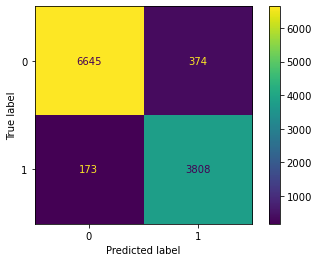

In [27]:
print("Test loss:", test_loss)
print("Test accuracy:", sklearn.metrics.accuracy_score(predicted_class, y_test))
print("Test F1 score:", sklearn.metrics.f1_score(predicted_class,y_test))
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, predicted_class)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.show()